In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import time
from IPython.display import display, Markdown
import pandas as pd

def configure_model(model):
    """
    Configure the Gurobi solver parameters to control optimization behavior.
    """
    model.Params.OutputFlag = 0       # Suppress solver output
    model.Params.TimeLimit = 500      # Set maximum solving time (seconds)
    model.Params.MIPGap = 0.05        # Set acceptable optimality gap (5%)
    model.Params.Presolve = 2         # Use aggressive presolve
    model.Params.MIPFocus = 1         # Focus on finding feasible solutions quickly
    model.Params.Heuristics = 0.8     # Enable heuristics to guide search
    model.Params.Threads = 8          # Use 8 threads for parallel computation

In [2]:
# Number of Processing Units (PUs)
m = 8

# Number of energy levels
K = 5

# Latency levels per energy level
L_levels = [25, 20, 15, 12, 10]

# Energy consumption per task at each level
E_levels = [13, 28, 38, 45, 120]

# Max PU energy limits
E_PU_max = [8000] * m

# PU CPU capacities
CPU_capacity = [3000] * m

# CPU frequency/usage level per energy level
f_v_levels = [30, 40, 60, 80, 100]

# Idle and max power of each PU
P_idle = [16] * m
P_max = [40] * m

# Total simulation time (time slots)
T_total = 300

# Total number of tasks
total_tasks = 150

# Task chain definitions (dict: chain_id → list of task indices)
from collections import Counter

chain_tasks = {
    0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    5: [50, 51, 52, 53, 54, 55, 56, 57],
    6: [58, 59, 60],
    7: [61, 62, 63],
    8: [64, 65, 66],
    9: [67, 68, 69],
    10: [70, 71, 72],
    11: [73, 74, 75],
    12: [76, 77, 78],
    13: [79, 80, 81],
    14: [82, 83, 84],
    15: [85, 86, 87],
    16: [88, 89, 90],
    17: [91, 92, 93],
    18: [94, 95, 96],
    19: [97, 98, 99]
}

num_chains = len(chain_tasks)

# Get total number of tasks from chain definitions
n = max(max(v) for v in chain_tasks.values()) + 1

# Maximum latency constraint per chain (with buffer factor)
buffer = 0.2  # 20% tolerance
L_max = [int(len(chain_tasks[k]) * min(L_levels) * (1 + buffer)) for k in chain_tasks]

In [3]:
#Gurobi Baseline and Optimal
def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, E_PU_max=None):
    model = gp.Model("MAF_Optimization")
    configure_model(model)
    if E_PU_max is None:
        E_PU_max = [8000] * m  

    
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    z = model.addVars(num_chains, vtype=GRB.BINARY, name="z")
    E_PU = model.addVars(m, name="E_PU")

    if baseline:
        for i in range(n):
            model.addConstr(y[i, K - 1] == delta[i])
            for k in range(K - 1):
                model.addConstr(y[i, k] == 0)

    for i in range(n):
        model.addConstr(gp.quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(gp.quicksum(y[i, k] for k in range(K)) == delta[i])
        for k in range(K):
            model.addConstr(y[i, k] <= delta[i])  # Ensure y[i,k]=0 if task is inactive

    for k in range(num_chains):
        model.addConstr(gp.quicksum(delta[i] for i in chain_tasks[k]) == z[k] * len(chain_tasks[k]))
        delay_chain = gp.quicksum(y[i, k_] * L_levels[k_] for i in chain_tasks[k] for k_ in range(K))
        model.addConstr(delay_chain <= L_max[k])

    for j in range(m):
        model.addConstr(
            gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * f_v_levels[k] for k in range(K)) for i in range(n)) <= CPU_capacity[j]
        )
        active_time = gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        U_j = active_time / T_total
        E_PU_expr = P_idle[j] * (T_total - active_time) + (P_max[j] - P_idle[j]) * U_j * T_total
        model.addConstr(E_PU[j] == E_PU_expr)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    total_task_energy = gp.quicksum(y[i, k] * E_levels[k] for i in range(n) for k in range(K))
    total_chain_accept = gp.quicksum(z[k] for k in range(num_chains))
    total_pu_energy = gp.quicksum(E_PU[j] for j in range(m))

    model.setObjective(
        alpha_1 * total_chain_accept - alpha_2 * total_task_energy - alpha_3 * total_pu_energy,
        GRB.MAXIMIZE
    )


    model.write("model_before_optimize.lp") 
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    model.write("model_after_optimize.lp")   

   

    if model.status == GRB.INFEASIBLE:
        print("🚫 Infeasible model! Computing IIS...")
        model.computeIIS()
        model.write("model_infeasible.ilp")
        print("\n🚨 Infeasible Constraints in IIS:")
        for c in model.getConstrs():
            if c.IISConstr:
                print(f" - {c.constrName}")
        return None

    if model.status != GRB.OPTIMAL:
        print("❌ Model optimization failed (status =", model.status, ").")
        return None


    #print(f"⏱️ Gurobi Runtime: {end_time - start_time:.2f} seconds")
    #print("\n📋 Chain Activation Overview:")
    #for k in range(num_chains):
        status = "✅ Activated" if z[k].X > 0.5 else "❌ Not activated"
        task_list = chain_tasks[k]
        print(f"Chain {k}: {status}, Tasks: {task_list}")
   

    accepted_chains = [k for k in range(num_chains) if z[k].X > 0.5]
    pu_assignment = [j for i in range(n) for j in range(m) if w[i, j].X > 0.5]
    pu_task_map = {}
    for task_id, pu_id in enumerate(pu_assignment):
        pu_task_map.setdefault(pu_id, []).append(task_id)

    task_energy_levels = [max((y[i, k].X, k) for k in range(K))[1] if delta[i].X > 0.5 else -1 for i in range(n)]
    #print("Task Energy Level Overview:")
    #for i in range(n):
        #if task_energy_levels[i] != -1:
            #print(f"Task {i} -> Level {task_energy_levels[i]} (Energy = {E_levels[task_energy_levels[i]]})")


    return {
    "model": "Gurobi-Baseline" if baseline else "Gurobi-Optimal",
    "E_PU_max": E_PU_max,
    "alphas": (alpha_1, alpha_2, alpha_3),
    "objective": model.ObjVal,
    "acceptance_rate": len(accepted_chains) / num_chains,  
    "total_pu_energy": sum(E_PU[j].X for j in range(m)),
    "total_task_energy": sum(y[i, k].X * E_levels[k] for i in range(n) for k in range(K)),
    "Runtime": model.Runtime,

    "Accepted Chains": len(accepted_chains),
    "Total Chains": num_chains,
    "PU Task Assignment": pu_task_map,
    "Task Energy Levels": task_energy_levels,
    "Activated Chain List": [1 if z[k].X > 0.5 else 0 for k in range(num_chains)]
}

def visualize_baseline_vs_optimal_extended(baseline, optimal, scenario_label=None):
    def add_text(ax, x_pos, height, text, threshold=0, offset=5, y_max_ratio=0.95):
        if height > threshold:
            y_max = ax.get_ylim()[1]
            safe_y = min(height + offset, y_max * y_max_ratio)
            ax.text(x_pos, safe_y, str(text), ha='center', fontsize=10)

    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle(
        f"Baseline vs Optimal Comparison Summary" + (f" ({scenario_label})" if scenario_label else ""),
        fontsize=16, y=1.02
    )


    # 1. Execution Time
    axs[0, 0].bar(['Baseline', 'Optimal'], [baseline['Runtime'], optimal['Runtime']], color=['skyblue', 'orange'])
    axs[0, 0].set_title("Execution Time (s)")
    axs[0, 0].set_ylabel("Time (s)")
    for i, val in enumerate([baseline['Runtime'], optimal['Runtime']]):
        add_text(axs[0, 0], i, val, f"{val:.2f}", offset=0.03)

    # 2. Chain Acceptance Rate
    baseline_accept = baseline['Accepted Chains'] / baseline['Total Chains']
    optimal_accept = optimal['Accepted Chains'] / optimal['Total Chains']
    axs[0, 1].bar(['Baseline', 'Optimal'], [baseline_accept, optimal_accept], color=['skyblue', 'orange'])
    axs[0, 1].set_title("Chain Acceptance Rate")
    axs[0, 1].set_ylabel("Ratio")
    for i, val in enumerate([baseline_accept, optimal_accept]):
        add_text(axs[0, 1], i, val, f"{val * 100:.1f}%", offset=0.03)

    # 3. Total Energy
    baseline_energy = baseline['total_pu_energy'] + baseline['total_task_energy']
    optimal_energy = optimal['total_pu_energy'] + optimal['total_task_energy']
    axs[0, 2].bar(['Baseline', 'Optimal'], [baseline_energy, optimal_energy], color=['skyblue', 'orange'])
    axs[0, 2].set_title("Total Energy Consumption")
    axs[0, 2].set_ylabel("Energy")
    for i, val in enumerate([baseline_energy, optimal_energy]):
        add_text(axs[0, 2], i, val, f"{val:.1f}", offset=3000)

    # 4. Energy Saving %
    saving_percent = (baseline_energy - optimal_energy) / baseline_energy * 100
    axs[1, 0].bar(['Baseline', 'Optimal'], [0, saving_percent], color=['skyblue', 'orange'])
    axs[1, 0].set_title("Energy Saving Compared to Baseline (%)")
    axs[1, 0].set_ylabel("Saving (%)")
    add_text(axs[1, 0], 1, saving_percent, f"{saving_percent:.2f}%", offset=0.5)

    # 5. Task Count per PU
    pu_task_count_baseline = [len(baseline['PU Task Assignment'].get(j, [])) for j in range(m)]
    pu_task_count_optimal = [len(optimal['PU Task Assignment'].get(j, [])) for j in range(m)]
    x = np.arange(m)
    axs[1, 1].bar(x - 0.2, pu_task_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 1].bar(x + 0.2, pu_task_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 1].set_title("Task Count per PU")
    axs[1, 1].set_xlabel("PU Index")
    axs[1, 1].set_ylabel("Task Count")
    axs[1, 1].legend()
    for i in x:
        add_text(axs[1, 1], i - 0.2, pu_task_count_baseline[i], pu_task_count_baseline[i])
        add_text(axs[1, 1], i + 0.2, pu_task_count_optimal[i], pu_task_count_optimal[i])

    # 6. Task Count per Energy Level
    energy_count_baseline = [baseline['Task Energy Levels'].count(k) for k in range(K)]
    energy_count_optimal = [optimal['Task Energy Levels'].count(k) for k in range(K)]
    x2 = np.arange(K)
    axs[1, 2].bar(x2 - 0.2, energy_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 2].bar(x2 + 0.2, energy_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 2].set_title("Task Count per Energy Level")
    axs[1, 2].set_xlabel("Energy Level")
    axs[1, 2].set_ylabel("Task Count")
    axs[1, 2].set_xticks(x2)
    axs[1, 2].set_xticklabels([f"Level {i+1}" for i in range(K)])
    axs[1, 2].legend()
    for i in x2:
        add_text(axs[1, 2], i - 0.2, energy_count_baseline[i], energy_count_baseline[i])
        add_text(axs[1, 2], i + 0.2, energy_count_optimal[i], energy_count_optimal[i])

    # 7. Objective Function Value
    axs[2, 0].bar(['Baseline', 'Optimal'], [baseline['objective'], optimal['objective']], color=['skyblue', 'orange'])
    axs[2, 0].set_title("Objective Function Value")
    axs[2, 0].set_ylabel("Value")
    for i, val in enumerate([baseline['objective'], optimal['objective']]):
        add_text(axs[2, 0], i, val, f"{val:.2f}", offset=3000)

    axs[2, 1].axis('off')
    axs[2, 2].axis('off')

    plt.tight_layout()
    plt.show()



Testing with 4 Processing Units
Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


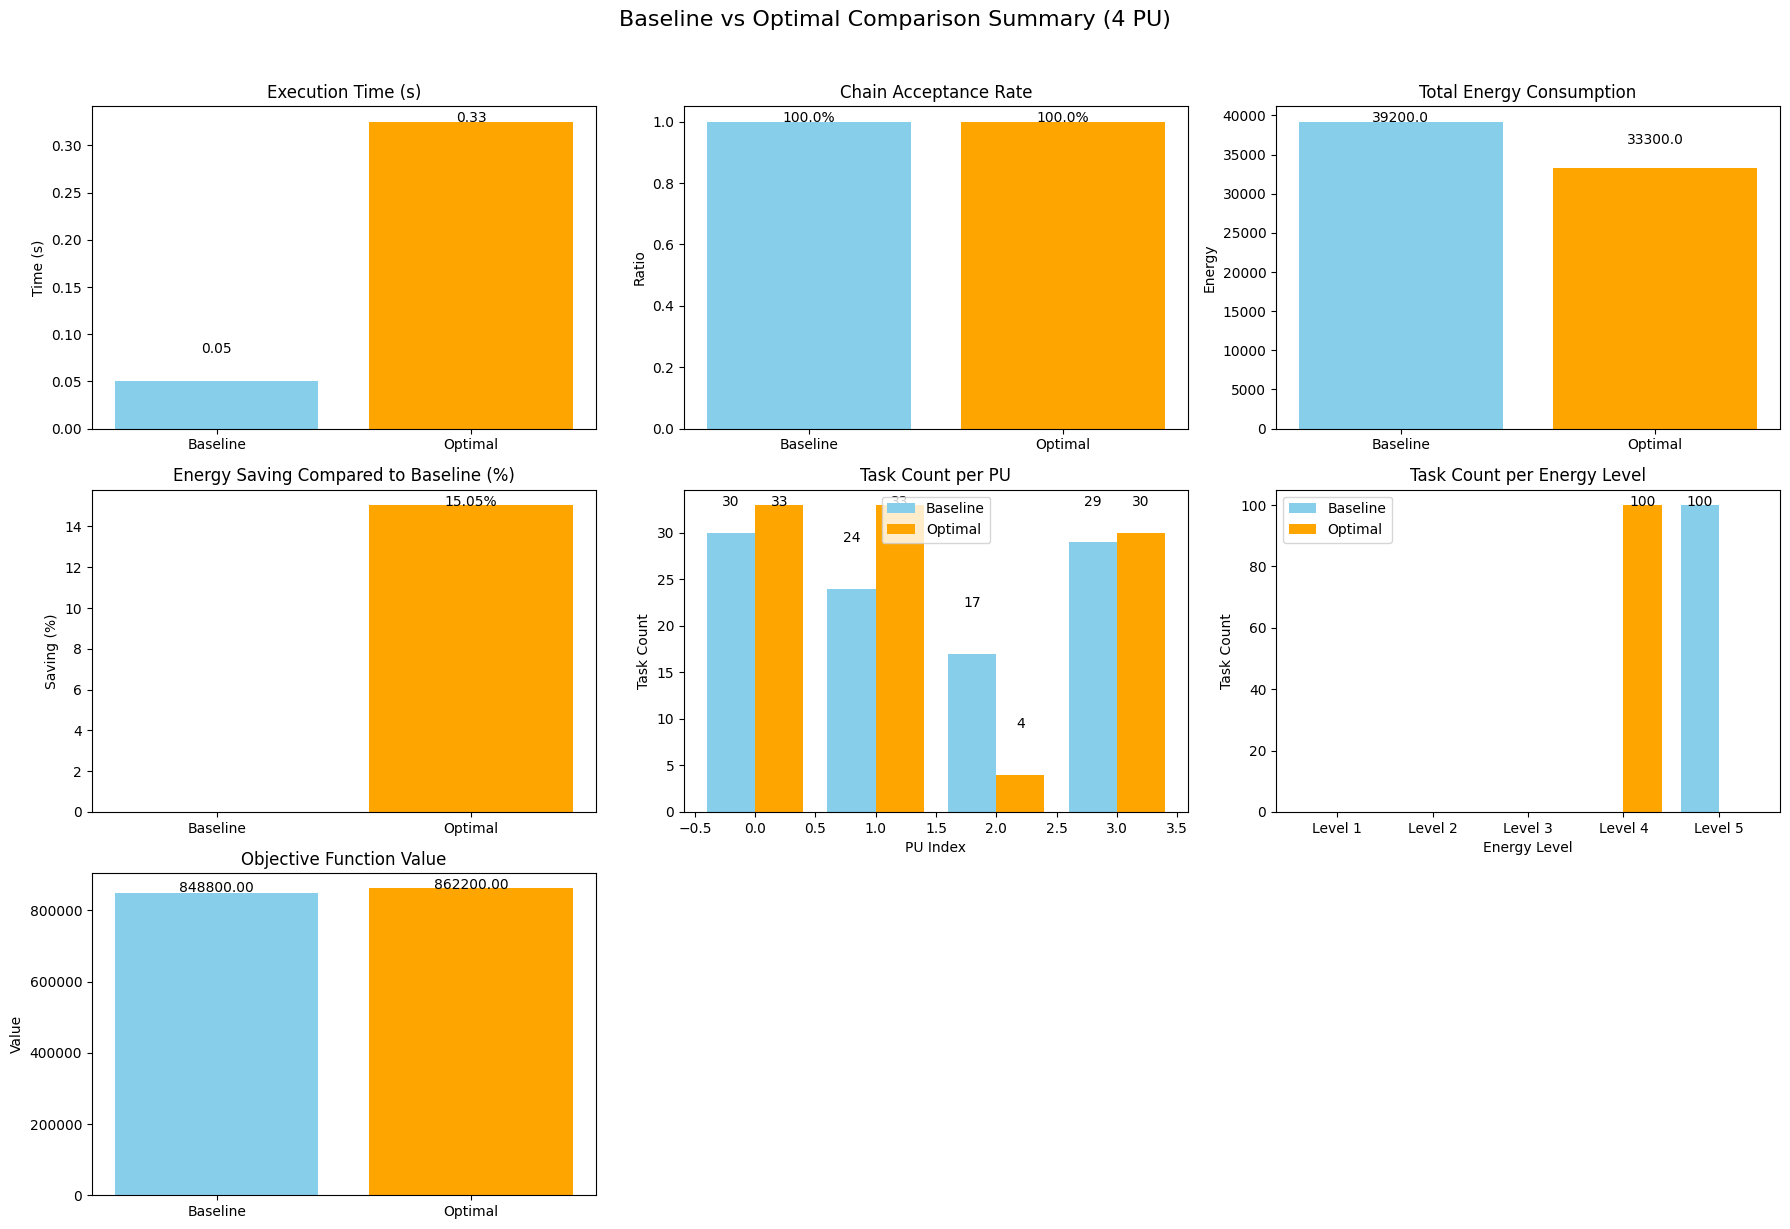


Testing with 6 Processing Units


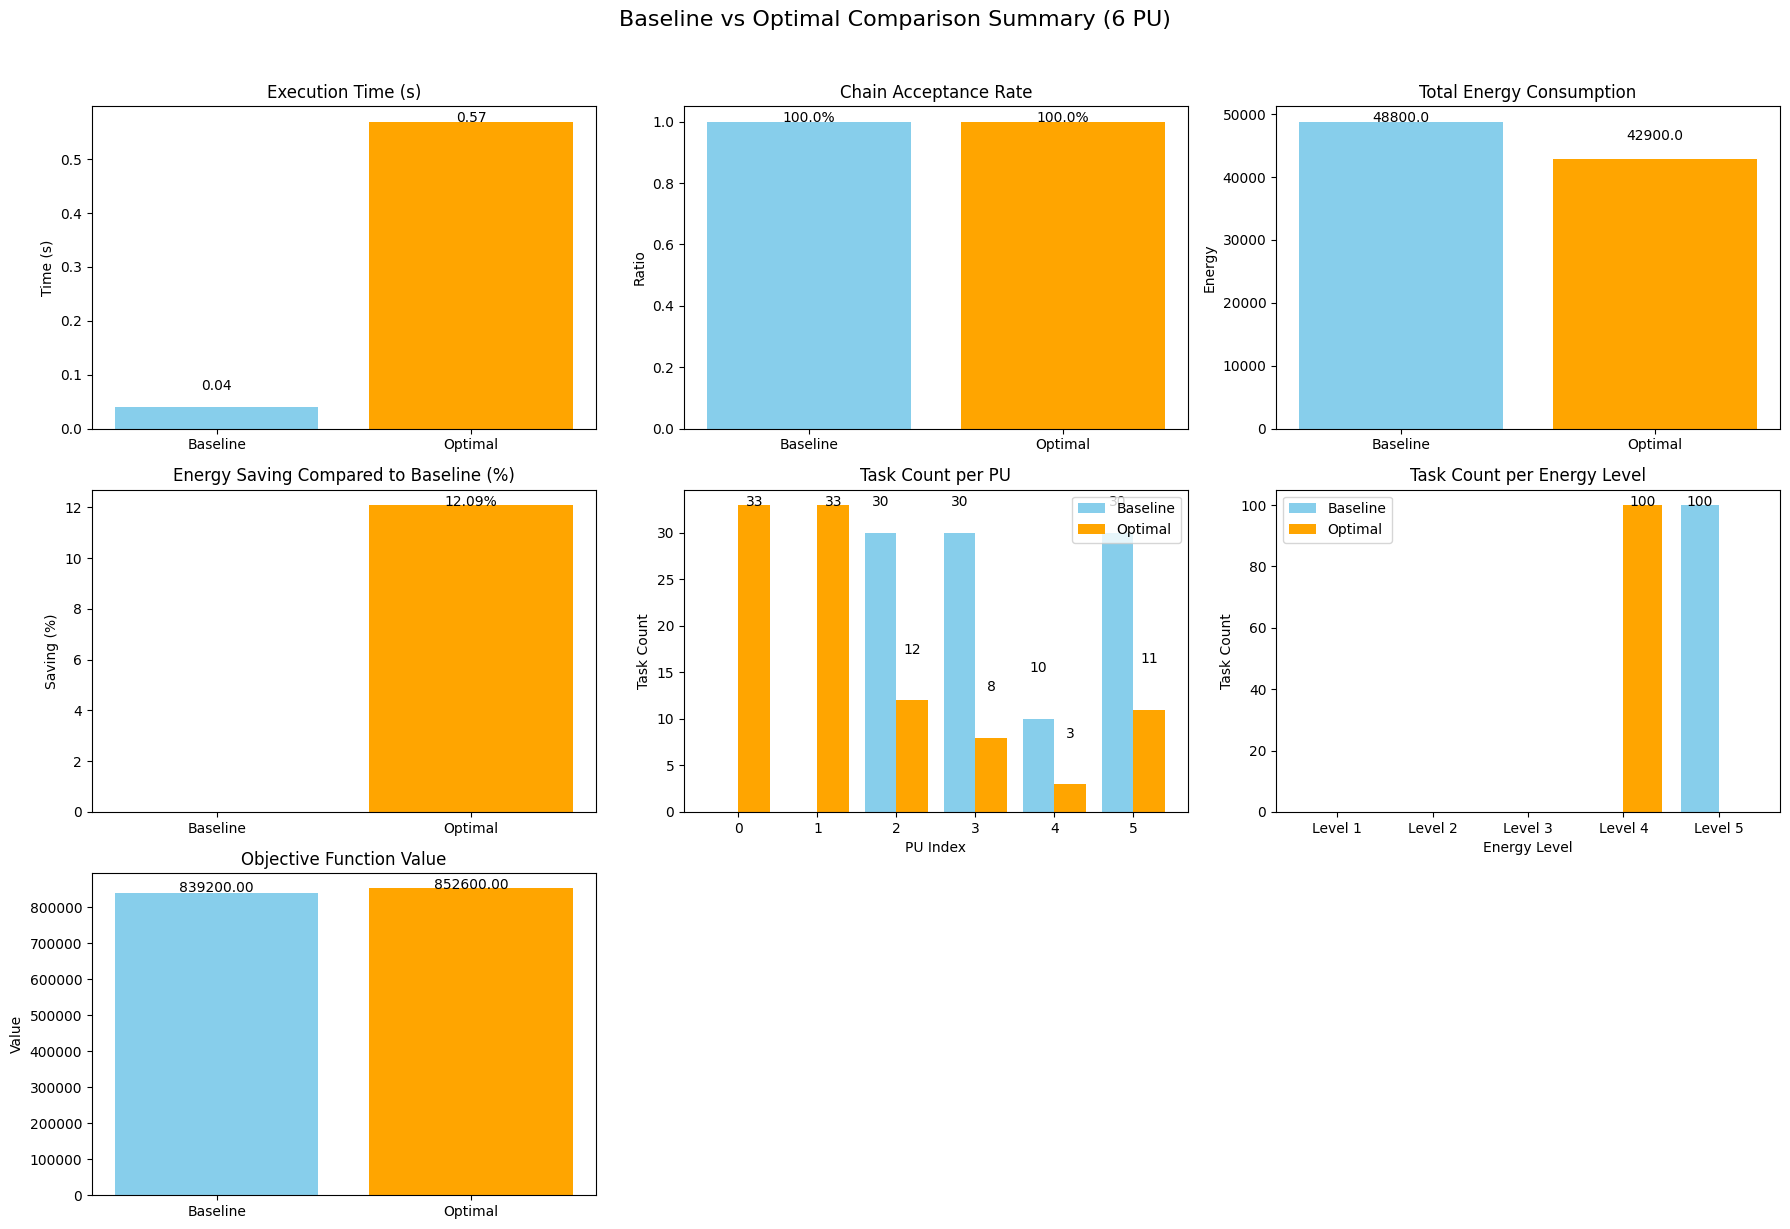


Testing with 8 Processing Units


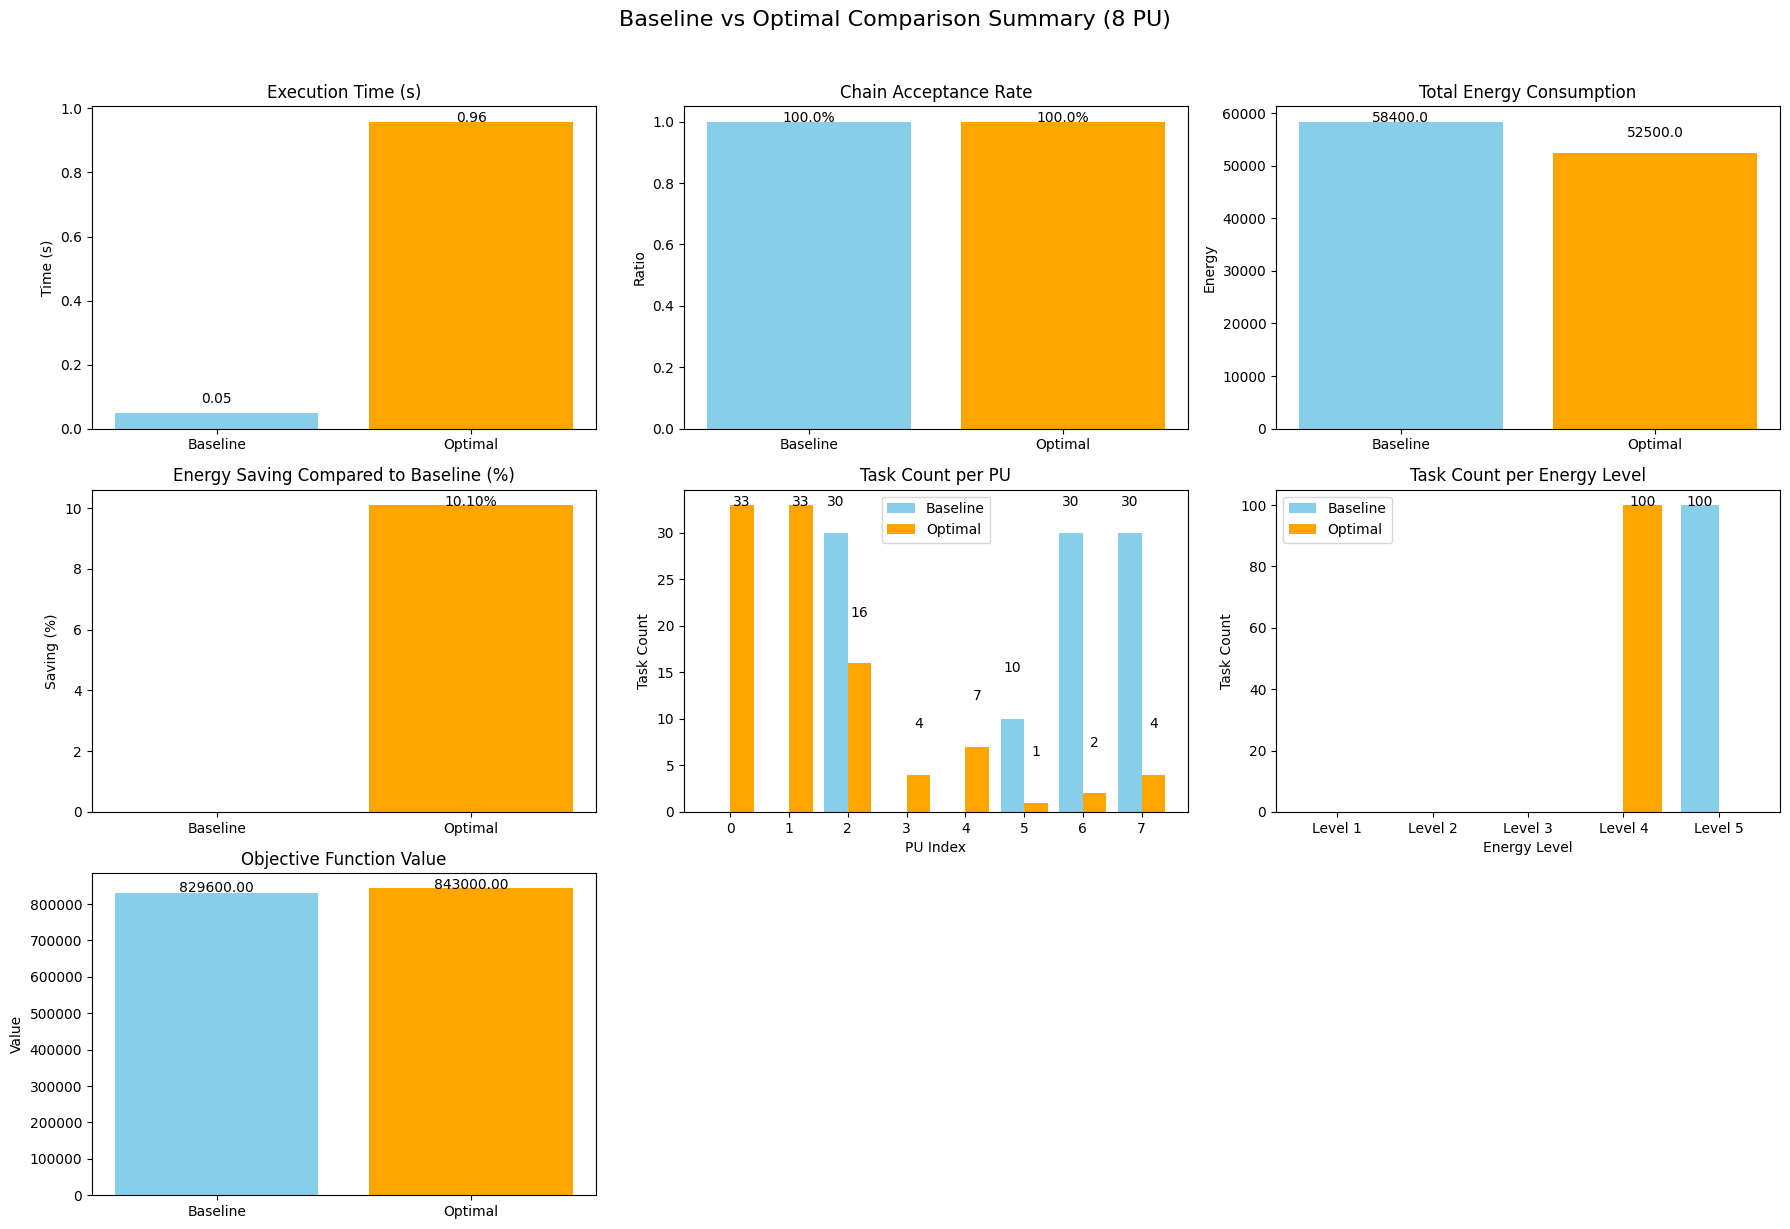


Testing with 10 Processing Units


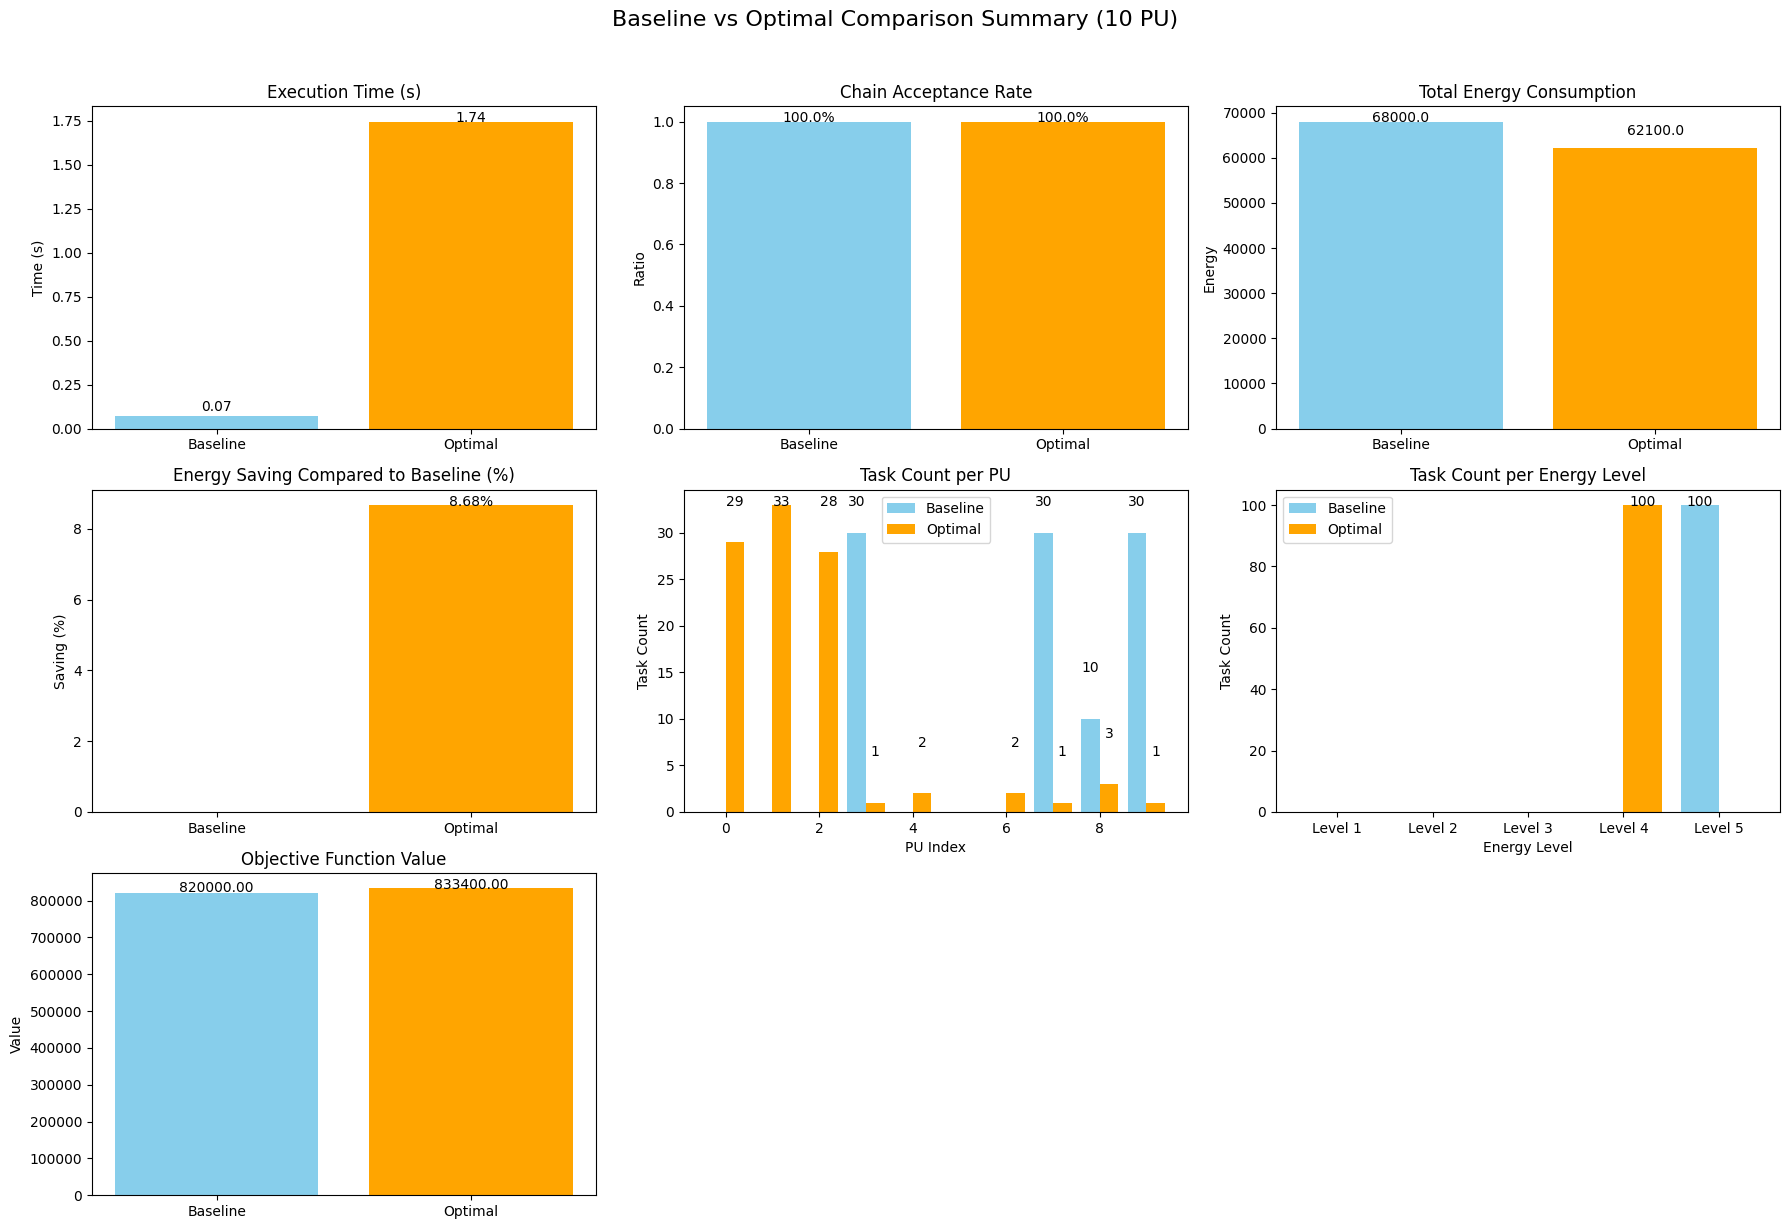

In [4]:

results_varying_pu = []


for m_test in [4, 6, 8, 10]:
    print(f"\nTesting with {m_test} Processing Units")

    m = m_test
    CPU_capacity = [3000] * m
    P_idle = [16] * m
    P_max = [40] * m
    E_PU_max = [8000] * m




    res_base = run_gurobi_model(
        alpha_1=45000, alpha_2=2, alpha_3=1,
        baseline=True,
        E_PU_max=E_PU_max
    )


    res_opt = run_gurobi_model(
        alpha_1=45000, alpha_2=2, alpha_3=1,
        baseline=False,
        E_PU_max=E_PU_max
    )


    if res_base and res_opt:
        res_base["PU_Count"] = m_test
        res_opt["PU_Count"] = m_test
        results_varying_pu.append((res_base, res_opt))

        visualize_baseline_vs_optimal_extended(res_base, res_opt, scenario_label=f"{m_test} PU")

